In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
data_dir = '/opt/Malware-Project/BigDataset/FEELScenarios/'

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'Processed', 'Client4', 'Day1', "comb_features_ben.csv"))
df.head()

,num_flows,avg_dur,std_dev_dur,percent_stdev_dur,total_size_of_flows_orig,total_size_of_flows_resp,ratio_of_sizes,percent_of_established_states,inbound_pckts,outbound_pckts,...,ratio_of_differ_subject_in_cert,ratio_of_differ_issuer_in_cert,ratio_of_differ_sandns_in_cert,ratio_of_same_subjects,ratio_of_same_issuer,ratio_is_same_CN_and_SNI,avg_certificate_exponent,is_SNI_in_top_level_domain,ratio_certificate_path_error,ratio_missing_cert_in_cert_path
0,1.0,445.491201,0.000000,0.000000,53020.0,24888.0,0.469408,1.000000,261.0,275.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
1,41.0,63.753415,36.536303,0.414634,36933.0,175896.0,4.762570,1.000000,1602.0,1801.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
2,3.0,15.502029,21.911534,0.333333,646.0,2643.0,4.091331,0.000000,12.0,13.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
3,1.0,10.579209,0.000000,0.000000,1910.0,6732.0,3.524607,1.000000,15.0,22.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
4,3.0,143.061461,133.159468,0.333333,4676.0,236240.0,50.521814,0.666667,92.0,108.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,-1.0,-1.0


In [4]:
df.columns

Index(['num_flows', 'avg_dur', 'std_dev_dur', 'percent_stdev_dur',
       'total_size_of_flows_orig', 'total_size_of_flows_resp',
       'ratio_of_sizes', 'percent_of_established_states', 'inbound_pckts',
       'outbound_pckts', 'periodicity_avg', 'periodicity_stdev', 'ssl_ratio',
       'average_public_key', 'tls_version_ratio', 'avg_cert_length',
       'stdev_cert_length', 'is_valid_certificate_during_capture',
       'amount_diff_certificates', 'num_domains_in_cert', 'cert_ratio',
       'num_certificate_path', 'x509_ssl_ratio', 'SNI_ssl_ratio',
       'self_signed_ratio', 'is_SNIs_in_SNA_dns', 'SNI_equal_DstIP',
       'is_CNs_in_SNA_dns', 'ratio_of_differ_SNI_in_ssl_log',
       'ratio_of_differ_subject_in_ssl_log',
       'ratio_of_differ_issuer_in_ssl_log', 'ratio_of_differ_subject_in_cert',
       'ratio_of_differ_issuer_in_cert', 'ratio_of_differ_sandns_in_cert',
       'ratio_of_same_subjects', 'ratio_of_same_issuer',
       'ratio_is_same_CN_and_SNI', 'avg_certificate_expo

In [5]:
df.describe()

,num_flows,avg_dur,std_dev_dur,percent_stdev_dur,total_size_of_flows_orig,total_size_of_flows_resp,ratio_of_sizes,percent_of_established_states,inbound_pckts,outbound_pckts,...,ratio_of_differ_subject_in_cert,ratio_of_differ_issuer_in_cert,ratio_of_differ_sandns_in_cert,ratio_of_same_subjects,ratio_of_same_issuer,ratio_is_same_CN_and_SNI,avg_certificate_exponent,is_SNI_in_top_level_domain,ratio_certificate_path_error,ratio_missing_cert_in_cert_path
count,416.000000,416.000000,416.000000,416.000000,4.160000e+02,4.160000e+02,416.000000,416.000000,416.000000,416.000000,...,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.000000,416.0,416.0
mean,3.009615,367.519121,74.753646,0.146275,1.607526e+04,2.936880e+05,50.363344,0.929071,304.132212,331.348558,...,-0.980769,-0.980769,-0.980769,-0.971154,-0.971154,-0.973558,471.641827,-0.012019,-1.0,-1.0
std,6.393890,1645.899872,844.392199,0.218326,7.846250e+04,2.273792e+06,362.064082,0.192014,2857.937553,3470.623243,...,0.137501,0.137501,0.137501,0.217620,0.217620,0.200656,5552.109764,0.109103,0.0,0.0
min,1.000000,0.000005,0.000000,0.000000,1.340000e+02,0.000000e+00,0.000000,0.000000,0.000000,2.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0
25%,1.000000,10.554657,0.000000,0.000000,1.910000e+03,6.288000e+03,1.716299,1.000000,24.000000,32.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.0,-1.0
50%,2.000000,106.317291,0.028899,0.000000,2.936000e+03,1.153200e+04,3.600720,1.000000,47.000000,56.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.0,-1.0
75%,3.000000,244.049213,19.282848,0.333333,7.678750e+03,2.671550e+04,6.729675,1.000000,119.750000,124.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.0,-1.0
max,76.000000,26782.765993,15930.695930,1.000000,1.434297e+06,4.205366e+07,5884.923594,1.000000,57505.000000,70503.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,65537.000000,0.000000,-1.0,-1.0


In [12]:
df2 = pd.read_csv(os.path.join(data_dir, 'Raw', 'Malware', 'CTU-Malware-Capture-Botnet-327-2', 'Day1', "comb_features.csv"))
df2.head()

,num_flows,avg_dur,std_dev_dur,percent_stdev_dur,total_size_of_flows_orig,total_size_of_flows_resp,ratio_of_sizes,percent_of_established_states,inbound_pckts,outbound_pckts,...,ratio_of_differ_subject_in_cert,ratio_of_differ_issuer_in_cert,ratio_of_differ_sandns_in_cert,ratio_of_same_subjects,ratio_of_same_issuer,ratio_is_same_CN_and_SNI,avg_certificate_exponent,is_SNI_in_top_level_domain,ratio_certificate_path_error,ratio_missing_cert_in_cert_path
0,2.0,1.792491,0.005224,0.0,1130.0,6992.0,6.187611,1.0,21.0,21.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2.0,1.290481,0.005368,0.0,1002.0,14842.0,14.812375,1.0,20.0,18.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1.0,100.400788,0.000000,0.0,1092.0,3754.0,3.437729,1.0,16.0,17.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2.0,100.404977,0.025169,0.0,2184.0,7508.0,3.437729,1.0,27.0,29.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1.0,1.786517,0.000000,0.0,565.0,3496.0,6.187611,1.0,10.0,10.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [13]:
df.SNI_equal_DstIP.describe()

count    416.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: SNI_equal_DstIP, dtype: float64

In [14]:
df2.self_signed_ratio.describe()

count    72.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: self_signed_ratio, dtype: float64

In [9]:
df2.ssl_ratio.describe()

count    72.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: ssl_ratio, dtype: float64

In [8]:
for column in df.columns:
    if df[column].describe()["mean"] == -1 or df[column].describe()["mean"] == 0:
        print(column)

self_signed_ratio
SNI_equal_DstIP
ratio_certificate_path_error
ratio_missing_cert_in_cert_path


In [12]:
for column in df2.columns:
    if df2[column].describe()["mean"] == -1:
        print(column)

periodicity_avg
periodicity_stdev
average_public_key
avg_cert_length
stdev_cert_length
is_valid_certificate_during_capture
num_domains_in_cert
cert_ratio
is_SNIs_in_SNA_dns
is_CNs_in_SNA_dns
ratio_of_differ_SNI_in_ssl_log
ratio_of_differ_issuer_in_ssl_log
ratio_of_differ_subject_in_cert
ratio_of_differ_issuer_in_cert
ratio_of_differ_sandns_in_cert
ratio_of_same_subjects
ratio_of_same_issuer
ratio_is_same_CN_and_SNI
avg_certificate_exponent
is_SNI_in_top_level_domain
ratio_certificate_path_error
ratio_missing_cert_in_cert_path


# Anomaly detection tests

## Create benign dataset for each day

In [80]:
data = dict()
for j in range(1, 6):
    data["Day"+str(j)] = pd.DataFrame()
    for i in range(1, 11):
        df_temp = pd.read_csv(os.path.join(data_dir, 'Processed', 'Client'+str(i), 'Day'+str(j), "comb_features_ben.csv"))
        data["Day"+str(j)] = pd.concat([data["Day"+str(j)], df_temp], ignore_index=True)
    

In [81]:
for i in range(1, 6):
    print(f'Size of Day{i} dataframe: {len(data["Day"+str(i)])}')

Size of Day1 dataframe: 6807
Size of Day2 dataframe: 5892
Size of Day3 dataframe: 5412
Size of Day4 dataframe: 6085
Size of Day5 dataframe: 6058


In [82]:
for i in range(1, 6):
    for column in df.columns:
        if data["Day"+str(j)][column].describe()["mean"] == -1:
            print(i, column)

1 ratio_certificate_path_error
1 ratio_missing_cert_in_cert_path
2 ratio_certificate_path_error
2 ratio_missing_cert_in_cert_path
3 ratio_certificate_path_error
3 ratio_missing_cert_in_cert_path
4 ratio_certificate_path_error
4 ratio_missing_cert_in_cert_path
5 ratio_certificate_path_error
5 ratio_missing_cert_in_cert_path


In [83]:
# Drop column "ssl_ratio"
for i in range(1, 6):
    data["Day"+str(i)] = data["Day"+str(i)].drop(["ssl_ratio", "self_signed_ratio", "SNI_equal_DstIP", "ratio_certificate_path_error", "ratio_missing_cert_in_cert_path"], axis=1)
    data["Day"+str(i)] = data["Day"+str(i)].drop_duplicates()

In [84]:
# Final sizes
for i in range(1, 6):
    print(f'Size of Day{i} dataframe: {len(data["Day"+str(i)])}')


Size of Day1 dataframe: 6805
Size of Day2 dataframe: 5886
Size of Day3 dataframe: 5409
Size of Day4 dataframe: 6079
Size of Day5 dataframe: 6057


## Create malware dataset (Day1)

In [85]:
mal_data = dict()
mal_folders = ['CTU-Malware-Capture-Botnet-346-1', 'CTU-Malware-Capture-Botnet-327-2', 'CTU-Malware-Capture-Botnet-230-1', 'CTU-Malware-Capture-Botnet-219-2']

for folder in mal_folders:
    mal_data[folder] = pd.DataFrame()
    df_temp = pd.read_csv(os.path.join(data_dir, 'Raw', 'Malware', folder, 'Day1', "comb_features.csv"))
    mal_data[folder] = pd.concat([mal_data[folder], df_temp], ignore_index=True)

In [86]:
for folder in mal_folders:
    print(f'Size of {folder} dataframe: {len(mal_data[folder])}')

Size of CTU-Malware-Capture-Botnet-346-1 dataframe: 48
Size of CTU-Malware-Capture-Botnet-327-2 dataframe: 72
Size of CTU-Malware-Capture-Botnet-230-1 dataframe: 4
Size of CTU-Malware-Capture-Botnet-219-2 dataframe: 21


In [87]:
for folder in mal_folders:
    for column in df.columns:
        if mal_data[folder][column].describe()["mean"] == -1:
            print(folder, column)

CTU-Malware-Capture-Botnet-346-1 num_domains_in_cert
CTU-Malware-Capture-Botnet-346-1 is_SNIs_in_SNA_dns
CTU-Malware-Capture-Botnet-346-1 is_CNs_in_SNA_dns
CTU-Malware-Capture-Botnet-346-1 ratio_of_differ_SNI_in_ssl_log
CTU-Malware-Capture-Botnet-346-1 ratio_of_differ_sandns_in_cert
CTU-Malware-Capture-Botnet-346-1 is_SNI_in_top_level_domain
CTU-Malware-Capture-Botnet-346-1 ratio_certificate_path_error
CTU-Malware-Capture-Botnet-346-1 ratio_missing_cert_in_cert_path
CTU-Malware-Capture-Botnet-327-2 periodicity_avg
CTU-Malware-Capture-Botnet-327-2 periodicity_stdev
CTU-Malware-Capture-Botnet-327-2 average_public_key
CTU-Malware-Capture-Botnet-327-2 avg_cert_length
CTU-Malware-Capture-Botnet-327-2 stdev_cert_length
CTU-Malware-Capture-Botnet-327-2 is_valid_certificate_during_capture
CTU-Malware-Capture-Botnet-327-2 num_domains_in_cert
CTU-Malware-Capture-Botnet-327-2 cert_ratio
CTU-Malware-Capture-Botnet-327-2 is_SNIs_in_SNA_dns
CTU-Malware-Capture-Botnet-327-2 is_CNs_in_SNA_dns
CTU-Malw

In [88]:
# Drop column "ssl_ratio"
for folder in mal_folders:
    mal_data[folder] = mal_data[folder].drop(["ssl_ratio", "self_signed_ratio", "SNI_equal_DstIP", "ratio_certificate_path_error", "ratio_missing_cert_in_cert_path"], axis=1)
    mal_data[folder] = mal_data[folder].drop_duplicates()

In [89]:
for folder in mal_folders:
    print(f'Size of {folder} dataframe: {len(mal_data[folder])}')

Size of CTU-Malware-Capture-Botnet-346-1 dataframe: 48
Size of CTU-Malware-Capture-Botnet-327-2 dataframe: 72
Size of CTU-Malware-Capture-Botnet-230-1 dataframe: 4
Size of CTU-Malware-Capture-Botnet-219-2 dataframe: 21


## Anomaly detection

### Isolation Forests

In [55]:
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing

In [58]:
# scaler = preprocessing.StandardScaler().fit(data["Day1"])
scaler = preprocessing.MinMaxScaler().fit(data["Day1"])
X = scaler.transform(data["Day1"])
iso = IsolationForest(n_estimators=50, 
                      contamination=0.01,
                      random_state=1337).fit(X)

In [59]:
X_test = scaler.transform(data["Day2"])
print(f'False positives: {100*sum(iso.predict(X_test) == -1) / len(X_test):.2f}%')

False positives: 0.92%


In [60]:
for folder in mal_folders:
    X_test_mal = scaler.transform(mal_data[folder])
    print(f'Detection {folder}: {100*sum(iso.predict(X_test_mal) == -1) / len(X_test_mal):.2f}%')

Detection CTU-Malware-Capture-Botnet-346-1: 4.17%
Detection CTU-Malware-Capture-Botnet-327-2: 0.00%
Detection CTU-Malware-Capture-Botnet-230-1: 0.00%
Detection CTU-Malware-Capture-Botnet-219-2: 61.90%


### LOF

In [61]:
from sklearn.neighbors import LocalOutlierFactor

In [62]:
lof = LocalOutlierFactor(n_neighbors=5, novelty=True, contamination=0.02)

In [63]:
# scaler = preprocessing.StandardScaler().fit(data["Day1"])
scaler = preprocessing.MinMaxScaler().fit(data["Day1"])
X = scaler.transform(data["Day1"])
lof.fit(X)

LocalOutlierFactor(contamination=0.02, n_neighbors=5, novelty=True)

In [64]:
X_test = scaler.transform(data["Day2"])
print(f'False positives: {100*sum(lof.predict(X_test) == -1) / len(X_test):.2f}%')

False positives: 1.73%


In [65]:
for folder in mal_folders:
    X_test_mal = scaler.transform(mal_data[folder])
    print(f'Detection {folder}: {100*sum(lof.predict(X_test_mal) == -1) / len(X_test_mal):.2f}% ({sum(lof.predict(X_test_mal)==-1)} out of {len(X_test_mal)})')

Detection CTU-Malware-Capture-Botnet-346-1: 0.00% (0 out of 48)
Detection CTU-Malware-Capture-Botnet-327-2: 94.44% (68 out of 72)
Detection CTU-Malware-Capture-Botnet-230-1: 50.00% (2 out of 4)
Detection CTU-Malware-Capture-Botnet-219-2: 9.52% (2 out of 21)


### One class SVM

In [66]:
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM

In [67]:
# It does better with nu=0.02 but higher FP
scaler = preprocessing.MinMaxScaler().fit(data["Day1"])
X = scaler.transform(data["Day1"])
# svm_ = OneClassSVM(nu=0.02, kernel="linear", gamma=0.1).fit(X)
svm_ = SGDOneClassSVM(nu=0.01).fit(X)

In [68]:
X_test = scaler.transform(data["Day2"])
print(f'False positives: {100*sum(svm_.predict(X_test) == -1) / len(X_test):.2f}% ({sum(svm_.predict(X_test)==-1)} out of {len(X_test)})')

False positives: 0.99% (58 out of 5886)


In [69]:
for folder in mal_folders:
    X_test_mal = scaler.transform(mal_data[folder])
    print(f'{folder} detected: {100*sum(svm_.predict(X_test_mal) == -1) / len(X_test_mal):.2f}% ({sum(svm_.predict(X_test_mal)==-1)} out of {len(X_test_mal)})')

CTU-Malware-Capture-Botnet-346-1 detected: 0.00% (0 out of 48)
CTU-Malware-Capture-Botnet-327-2 detected: 94.44% (68 out of 72)
CTU-Malware-Capture-Botnet-230-1 detected: 0.00% (0 out of 4)
CTU-Malware-Capture-Botnet-219-2 detected: 14.29% (3 out of 21)


### Autoencoders (NN)

In [105]:
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [162]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(36)),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(20, activation='elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation='elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(20, activation='elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(36, activation='elu')
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [163]:
EPOCHS = 8
BATCH_SIZE = 64

scaler = preprocessing.MinMaxScaler()

X = scaler.fit_transform(data["Day4"])
X_test = scaler.transform(data["Day5"])

X_train , X_val = train_test_split(X, test_size=0.2, random_state=8181)

# X = data["Day1"]
# X_test = data["Day2"]

history = model.fit(
    X_train, X_train,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
#     callbacks=cb,
    validation_data=(X_val, X_val)
)


Epoch 1/8
95/95 [==============================] - 2s 11ms/step - loss: 0.0608 - val_loss: 0.0118
Epoch 2/8
95/95 [==============================] - 1s 8ms/step - loss: 0.0206 - val_loss: 0.0067
Epoch 3/8
95/95 [==============================] - 1s 8ms/step - loss: 0.0133 - val_loss: 0.0048
Epoch 4/8
95/95 [==============================] - 1s 9ms/step - loss: 0.0107 - val_loss: 0.0042
Epoch 5/8
95/95 [==============================] - 1s 7ms/step - loss: 0.0092 - val_loss: 0.0038
Epoch 6/8
95/95 [==============================] - 1s 7ms/step - loss: 0.0082 - val_loss: 0.0034
Epoch 7/8
95/95 [==============================] - 1s 8ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 8/8
95/95 [==============================] - 1s 6ms/step - loss: 0.0072 - val_loss: 0.0030


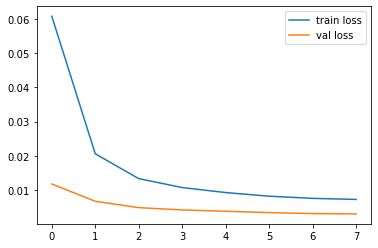

In [164]:
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()

In [165]:
rec_ben = model.predict(X_test)
mse_ben = np.mean(np.power(X_test - rec_ben, 2), axis=1)


rec_mal = dict()
mse_mal = dict()
num_malware = 0
for folder in mal_folders:
    X_test_mal = scaler.transform(mal_data[folder])
    num_malware += X_test_mal.shape[0]
    rec_mal[folder] = model.predict(X_test_mal)
    mse_mal[folder] = np.mean(np.power(X_test_mal - rec_mal[folder], 2), axis=1)

num_malware

145

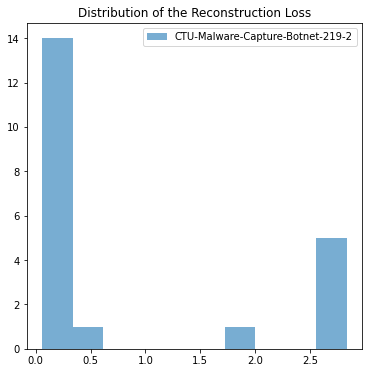

In [166]:
fig, ax = plt.subplots(figsize=(6,6))

# ax.hist(mse_ben, bins=10, density=False, label="clean", alpha=.6, color="green")
# for folder in mal_folders:
# ax.hist(mse_mal["CTU-Malware-Capture-Botnet-346-1"], bins=10, density=False, label="CTU-Malware-Capture-Botnet-346-1", alpha=.6)
# ax.hist(mse_mal["CTU-Malware-Capture-Botnet-327-2"], bins=10, density=False, label="CTU-Malware-Capture-Botnet-327-2", alpha=.6)
# ax.hist(mse_mal["CTU-Malware-Capture-Botnet-230-1"], bins=10, density=False, label="CTU-Malware-Capture-Botnet-230-1", alpha=.6)
ax.hist(mse_mal["CTU-Malware-Capture-Botnet-219-2"], bins=10, density=False, label="CTU-Malware-Capture-Botnet-219-2", alpha=.6)


plt.title("Distribution of the Reconstruction Loss")
plt.legend()

In [167]:
# The number of faulty samples for a 2% FPR (on the training set)
rec_ben = model.predict(X_val)
mse_ben = np.mean(np.power(X_val - rec_ben, 2), axis=1)

num = 0.01*len(X_val)

th = 0.001
while (sum(mse_ben > th) > num):
    th += 0.001
print(f"Calculated threshold: {th:.5f}")

# Measure in the testset
rec_ben = model.predict(X_test)
mse_ben = np.mean(np.power(X_test - rec_ben, 2), axis=1)
print(f'False positives on next day: { 100*sum(mse_ben > th) / len(X_test):.2f}% ({sum(mse_ben > th)} out of {len(X_test)})')
anomalies_ben = sum(mse_ben > th)
num_examples_test = X_test.shape[0]

Calculated threshold: 0.03900
False positives on next day: 1.42% (86 out of 6057)


In [168]:
anomalies_mal = 0
for folder in mal_folders:
    anomalies_mal += sum(mse_mal[folder] > th)
    print(f'{folder} detected: {100*sum(mse_mal[folder] > th) / len(mse_mal[folder]):.2f}% ({sum(mse_mal[folder] > th)} out of {len(mse_mal[folder])})')

CTU-Malware-Capture-Botnet-346-1 detected: 100.00% (48 out of 48)
CTU-Malware-Capture-Botnet-327-2 detected: 100.00% (72 out of 72)
CTU-Malware-Capture-Botnet-230-1 detected: 0.00% (0 out of 4)
CTU-Malware-Capture-Botnet-219-2 detected: 100.00% (21 out of 21)


In [169]:
fp = anomalies_ben
tp = anomalies_mal
tn = num_examples_test - fp
fn = num_malware - tp

accuracy = (tp + tn) / (num_examples_test + num_malware)
tpr = tp / num_malware
fpr = fp / num_examples_test

# Metrics on the test set for both malware and benign data
print(f"Centralized accuracy: {100*accuracy:.2f}%")
print(f"Centralized tpr: {100*tpr:.2f}%")
print(f"Centralized fpr: {100*fpr:.2f}%")

Centralized accuracy: 98.55%
Centralized tpr: 97.24%
Centralized fpr: 1.42%
